In [1]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import io

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [2]:
train_df = pd.read_csv('train.csv')
valid_df = pd.read_csv('test.csv')

## Image Augmentation:
(no code changes needed)

In [3]:
IMG_SIZE = (224, 224)

In [4]:
train_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)

train_gen = train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'img_path',
                                         y_col = 'class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 9
                                         )

# Note that the validation data should not be augmented! We only want to do some basic intensity rescaling here
val_idg = ImageDataGenerator(rescale=1. / 255.0
                                 )

val_gen = val_idg.flow_from_dataframe(dataframe=valid_df, 
                                         directory=None, 
                                         x_col = 'img_path',
                                         y_col = 'class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 6) ## We've only been provided with 6 validation images

Found 20 validated image filenames belonging to 2 classes.
Found 6 validated image filenames belonging to 2 classes.


In [5]:
## Pull a single large batch of random validation data for testing after each epoch
testX, testY = val_gen.next()

## Load in VGG16 with pre-trained ImageNet weights: 
(No code changes needed):

In [8]:
model = VGG16(include_top=True, weights='imagenet')

In [9]:
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

In [10]:
## Now, choose which layers of VGG16 we actually want to fine-tune (if any)
## Here, we'll freeze all but the last convolutional layer
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

In [11]:
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(256, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1, activation='relu'))

In [12]:
## Set our optimizer, loss function, and learning rate
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [13]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [14]:
## Run for 10 epochs to see if any learning occurs:
history = new_model.fit_generator(train_gen, 
                                  validation_data = (testX, testY), 
                                  epochs = 10)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
3/3 [==============================] - 3s 864ms/step - loss: 5.4090 - binary_accuracy: 0.6500 - val_loss: 0.6195 - val_binary_accuracy: 0.6667
Epoch 2/10
3/3 [==============================] - 3s 1s/step - loss: 4.0380 - binary_accuracy: 0.7000 - val_loss: 1.0883 - val_binary_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 4s 1s/step - loss: 9.3983 - binary_accuracy: 0.3000 - val_loss: 3.4268 - val_binary_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 2s 784ms/step - loss: 5.4713 - binary_accuracy: 0.6000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 5/10
3/3 [==============================] - 2s 774ms/step - loss: 10.1421 - binary_accuracy: 0.2500 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 6/10
3/3 [==============================] - 2s 778ms/step - loss: 3.9768 - binary_accuracy: 0.7000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch

### Write a function below to plot the output of your training that is stored in the 'history' variable from above: 

In [15]:
# Define a function here that will plot loss, val_loss, binary_accuracy, and val_binary_accuracy over all of 
# your epochs: 
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

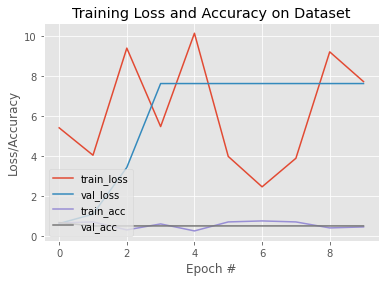

In [16]:
plot_history(history)

## Try a model with less dropout, same learning rate: 

In [17]:
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.3))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.3))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(256, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
new_model.add(Dense(1, activation='sigmoid'))

In [18]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [19]:
history = new_model.fit_generator(train_gen, 
                                  validation_data = (testX, testY), 
                                  epochs = 10)

Epoch 1/10
3/3 [==============================] - 3s 843ms/step - loss: 1.0162 - binary_accuracy: 0.4500 - val_loss: 1.0214 - val_binary_accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - 3s 1s/step - loss: 0.9439 - binary_accuracy: 0.5000 - val_loss: 0.8221 - val_binary_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 3s 1s/step - loss: 0.6153 - binary_accuracy: 0.7500 - val_loss: 0.6756 - val_binary_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 2s 791ms/step - loss: 0.6874 - binary_accuracy: 0.5500 - val_loss: 0.6687 - val_binary_accuracy: 0.6667
Epoch 5/10
3/3 [==============================] - 3s 1s/step - loss: 0.7050 - binary_accuracy: 0.5500 - val_loss: 0.6792 - val_binary_accuracy: 0.6667
Epoch 6/10
3/3 [==============================] - 2s 792ms/step - loss: 0.6301 - binary_accuracy: 0.6000 - val_loss: 0.6508 - val_binary_accuracy: 0.6667
Epoch 7/10
3/3 [==============================] - 3s 1s/step - loss: 0.6264 - binary_

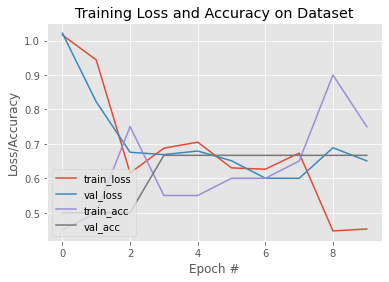

In [20]:
plot_history(history)

## Finally, try a model with the same amount of dropout as you initiall had, but a slower learning rate: 

In [21]:
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(256, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
new_model.add(Dense(1, activation='sigmoid'))

In [22]:
## Set our optimizer, loss function, and learning rate
optimizer = Adam(lr=1e-6)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [23]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [24]:
history = new_model.fit_generator(train_gen, 
                                  validation_data = (testX, testY), 
                                  epochs = 10)

Epoch 1/10
3/3 [==============================] - 3s 1s/step - loss: 1.1751 - binary_accuracy: 0.5000 - val_loss: 0.7183 - val_binary_accuracy: 0.5000
Epoch 2/10
3/3 [==============================] - 3s 1s/step - loss: 0.9872 - binary_accuracy: 0.5000 - val_loss: 0.7163 - val_binary_accuracy: 0.5000
Epoch 3/10
3/3 [==============================] - 2s 772ms/step - loss: 1.2460 - binary_accuracy: 0.5000 - val_loss: 0.7135 - val_binary_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 2s 763ms/step - loss: 1.0019 - binary_accuracy: 0.4000 - val_loss: 0.7108 - val_binary_accuracy: 0.5000
Epoch 5/10
3/3 [==============================] - 2s 770ms/step - loss: 1.0789 - binary_accuracy: 0.5000 - val_loss: 0.7080 - val_binary_accuracy: 0.5000
Epoch 6/10
3/3 [==============================] - 3s 1s/step - loss: 1.1116 - binary_accuracy: 0.5000 - val_loss: 0.7055 - val_binary_accuracy: 0.5000
Epoch 7/10
3/3 [==============================] - 2s 791ms/step - loss: 1.1748 - bina

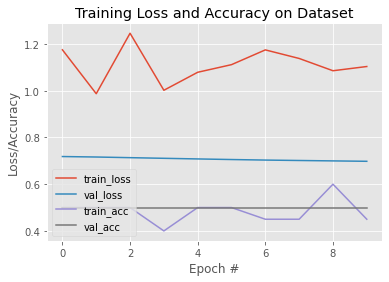

In [25]:
plot_history(history)